In [1]:
# import statements
import numpy as np
import xarray as xr
import glob
import random
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep
import sys
import matplotlib.pyplot as plt
import PolarTestingTrainingSplit_CV
from matplotlib.colors import LinearSegmentedColormap

# Get names of models in which we are testing on
path_to_data = '/home/disk/pna2/aodhan/CMIP6/historical_monthly_tas_google/trendmap/*_TrendMaps.nc'
ModelNames = [i[68:-23] for i in glob.glob(path_to_data)]

# Get observational data
observational_trends = glob.glob('/home/disk/p/aodhan/SurfaceTrendLearing/PolarTASNDJFM/TASObsTrends/*NDJFM.npy')
observational_trend_maps = [np.load(observational_trends[i]) for i in range(0,len(observational_trends))]
latitudes = np.linspace(-88.75,88.75,72)
weights = np.cos(np.deg2rad(latitudes)) # these will be used to weight predictors
observational_trend_maps_weighted = np.multiply(observational_trend_maps, weights[np.newaxis,:,np.newaxis])
observational_trend_maps_reshaped = np.reshape(observational_trend_maps_weighted, (3, 72*144))

# Create Custom Color Map
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

# Do CV train-test-split 
TrainingPredictorData, TrainingTargetData, TestingPredictorData, TestingTargetData, TestingTotalTrend = PolarTestingTrainingSplit_CV.training_testing_split(path_to_data)


In [15]:
from sklearn.cross_decomposition import PLSRegression
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import datasets, layers, models, optimizers

ModelNames = np.arange(0,len(TrainingPredictorData), 1)
ModelNames = [ModelNames[i].astype(str) for i in range(0, len(ModelNames))]

# iterate over all CV folds (there should be eqaul number of CV folds as models)
NameValidatationPredictions = []
observationPredictions = []
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=4e-5, restore_best_weights=True)

for model_idx in range(0, len(ModelNames)):
    
    # reshape predictor data
    TrainingTargetDataShape = np.shape(TrainingTargetData[model_idx])
    TestinTargetDataShape = np.shape(TestingTargetData[model_idx])
    TrainingPredictorTimePeriod = np.reshape(TrainingPredictorData[model_idx], (int(len(TrainingPredictorData[model_idx])/26), 26, 72*144))
    TrainingTargetTimePeriod = np.reshape(TrainingTargetData[model_idx], (int(len(TrainingPredictorData[model_idx])/26), 26, 2, 3))
    
    X_train = TrainingPredictorTimePeriod[:,:,:]
    X_train = np.reshape(X_train, (len(X_train)*26,72*144))
    Y_train = TrainingTargetTimePeriod[:,:,:,:]
    Y_train = np.reshape(Y_train, (len(Y_train)*26,2,3))
    Y_train = Y_train[:,:,0]#[:,1]
    
    X_val = TrainingPredictorTimePeriod[:,-1,:]
    Y_val = TrainingTargetTimePeriod[:,-1,:,:]
    Y_val = Y_val[:,:,0]#[:,1]


    X_test = TestingPredictorData[model_idx]
    Y_test = TestingTargetData[model_idx]
    Y_test = Y_test[:,:,0]#[:,1]

    # scale all data
    t = MinMaxScaler()
    t.fit(X_train)
    X_train_scaled = t.transform(X_train)
    X_train_map = np.reshape(X_train_scaled, (len(X_train_scaled), 72,144,1))
    X_val_scaled = t.transform(X_val)
    X_val_map = np.reshape(X_val_scaled, (len(X_val_scaled), 72,144,1))
    X_test_scaled = t.transform(X_test)
    X_test_map = np.reshape(X_test_scaled, (len(X_test_scaled), 72,144,1))

    # Model Design
    model_path = '/home/disk/p/aodhan/SurfaceTrendLearing/PolarTASNDJFM/output/CNNPolarNDJFM/' + str(model_idx) + '.h5'
    print(model_path)
    #cnn = load_model(model_path)
    cnn = load_model(model_path, compile=False)
    cnn.compile() 

    # find predictions based on both models
    Y_pred_cnn = cnn.predict(X_test_map)
    Y_pred =  Y_pred_cnn 

    # Apply trained model to observations
    obs_train_scaled = t.transform(observational_trend_maps_reshaped)
    obs_map = np.reshape(obs_train_scaled, (len(obs_train_scaled), 72,144,1))
    Y_pred_obs = cnn.predict(obs_map)
    
    # Save output for plotting
    NameValidatationPredictions.append([ModelNames[model_idx], Y_test, Y_pred])
    observationPredictions.append(Y_pred_obs)
    
    print(ModelNames[model_idx])
    print(stats.pearsonr(Y_test[:,0], Y_pred[:,0]))
    print(np.nanmean(np.square((Y_test[:,0] - Y_pred[:,0]))))
    print(np.nanmean(np.square((Y_test[:,1] - Y_pred[:,1]))))


/home/disk/p/aodhan/SurfaceTrendLearing/PolarTASNDJFM/output/CNNPolarNDJFM/0.h5
1/1 [==============================] - 0s 76ms/step
0
(0.9740533638508511, 6.487056315227906e-21)
0.029699285
0.029693648
/home/disk/p/aodhan/SurfaceTrendLearing/PolarTASNDJFM/output/CNNPolarNDJFM/1.h5
1/1 [==============================] - 0s 35ms/step
1
(0.928762695257776, 1.2808960403777581e-05)
0.0056936727
0.0037667702
/home/disk/p/aodhan/SurfaceTrendLearing/PolarTASNDJFM/output/CNNPolarNDJFM/2.h5
1/1 [==============================] - 0s 27ms/step
2
(0.916368314356128, 1.0274025097484769e-20)
0.0075688
0.0060545574
/home/disk/p/aodhan/SurfaceTrendLearing/PolarTASNDJFM/output/CNNPolarNDJFM/3.h5
1/1 [==============================] - 0s 28ms/step
3
(0.966379071887822, 5.367677327430361e-06)
0.0072073066
0.004312651
/home/disk/p/aodhan/SurfaceTrendLearing/PolarTASNDJFM/output/CNNPolarNDJFM/4.h5
1/1 [==============================] - 0s 25ms/step
4
(0.9681221961428257, 1.0307911086808068e-06)
0.008013385


In [16]:
mean_predictions = np.nanmean(observationPredictions, axis=0)
mean_predictions

array([[0.14882126, 0.5754644 ],
       [0.02576462, 0.57697684],
       [0.15344232, 0.6122169 ]], dtype=float32)

In [13]:
mean_predictions = np.nanmean(observationPredictions, axis=0)
mean_predictions

array([[0.14882126, 0.5754644 ],
       [0.02576462, 0.57697684],
       [0.15344232, 0.6122169 ]], dtype=float32)

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykern

0.14882126
0.025764622
0.15344232


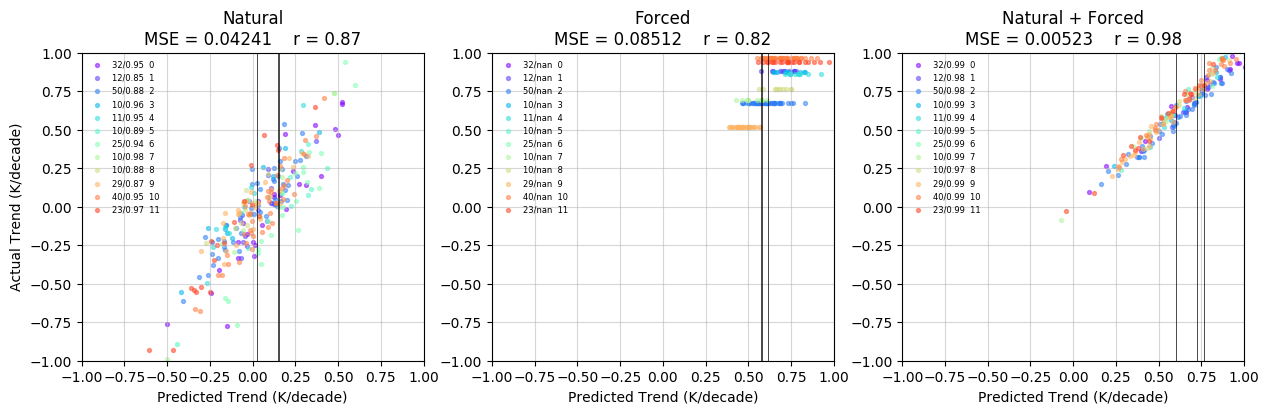

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 13))
NatValAndPred = []
ForValAndPred = []
TotValAndPred = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]    
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    TotalData = TestingTotalTrend[model_idx]
    N_ensembles = len(PredictedData)
    r_values = []

    for predictant_idx in range(3):
        axs_obj = axs[predictant_idx]

        # Natural Trend
        if predictant_idx == 0:
            val = ValidationData[:,0]
            pred = PredictedData[:,0]
            NatValAndPred.append([val, pred])
            axs_obj.set_ylabel('Actual Trend (K/decade)')

        # Forced Trend
        elif predictant_idx == 1:
            val = ValidationData[:,1]
            pred = PredictedData[:,1]
            ForValAndPred.append([val, pred])
        
        # Total Trend
        elif predictant_idx == 2:
            val = TotalData
            pred = PredictedData[:,0] + PredictedData[:,1]
            TotValAndPred.append([val, pred])

        #Plotting
        r = stats.pearsonr(val, pred)[0]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)
        axs_obj.set_ylim(-1,1.)
        axs_obj.set_xlim(-1,1.)
        axs_obj.set_xlabel('Predicted Trend (K/decade)')
        axs_obj.grid(alpha=0.5)

# Give scores across all models and ensemble members
NatValAndPred = np.array(NatValAndPred)
ForValAndPred = np.array(ForValAndPred)
TotValAndPred = np.array(TotValAndPred)
AllModelAllEnsemble = [NatValAndPred, ForValAndPred, TotValAndPred]
titles = ['Natural', 'Forced', 'Natural + Forced']
for i in range(3):
    axs_obj = axs[i]
    val_pred_data = AllModelAllEnsemble[i]
    vals = list(np.concatenate(val_pred_data[:,0]).flat)
    preds = list(np.concatenate(val_pred_data[:,1]).flat)
    allsimulation_r = stats.pearsonr(vals, preds)[0]
    avg_deviation = np.nanmean(np.square((np.array(vals) - np.array(preds))))
    axs_obj.set_title(titles[i] + '\nMSE = ' + str(avg_deviation)[:7]+ '    r = ' + str(allsimulation_r)[:4])

for obs in mean_predictions:
    for j in range(3):
        if j ==0:
            print(obs[0])
            axs[j].axvline(x=obs[0], c='black', linewidth=0.5)
        if j ==1:
            axs[j].axvline(x=obs[1], c='black', linewidth=0.5)
        if j ==2:
            axs[j].axvline(x=obs[0] + obs[1], c='black', linewidth=0.5)